In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
import symlib
import os


In [ ]:
def density_profile(base_dir, suite_name, snap, n_bins, r_min, r_max):
    """
    Measure the density profile of each host halo in a suite at a given snapshot,
    and save the profile as a pandas DataFrame (columns: halo_idx, r_scaled, rho_scaled).
    """

    # read and compute essential parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h  # M_sun
    eps = params['eps'] / h  # kpc
    H0 = params["H0"]  # km/s/Mpc
    Om0 = params["Om0"]

    H0_si = params["H0"] * u.km / u.s / u.Mpc
    G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
    rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
    rho_m = Om0 * rho_crit
  
    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]
        r_vir = host['rvir']  # kpc

        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        counts, _ = np.histogram(radi_scaled, bins=bins)
        shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
        mass_per_bin = counts * mp
        rho = mass_per_bin / shell_volumes  # Msun/kpc^3
        rho_scaled = rho / rho_m

        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "rho_scaled": rho_scaled
        })

        out_path = f"{base_dir}/output/{suite_name}/density_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} profile saved.")

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyLMC'

density_profile(base_dir, suite_name, snap=235, n_bins=40, r_min=0.001, r_max=1.5)


[Saved] Halo 000 profile saved.
[Saved] Halo 001 profile saved.
[Saved] Halo 002 profile saved.
[Saved] Halo 003 profile saved.
[Saved] Halo 004 profile saved.
[Saved] Halo 005 profile saved.
[Saved] Halo 006 profile saved.
[Saved] Halo 007 profile saved.
[Saved] Halo 008 profile saved.
[Saved] Halo 009 profile saved.
[Saved] Halo 010 profile saved.
[Saved] Halo 011 profile saved.
[Saved] Halo 012 profile saved.
[Saved] Halo 013 profile saved.
[Saved] Halo 014 profile saved.
[Saved] Halo 015 profile saved.
[Saved] Halo 016 profile saved.
[Saved] Halo 017 profile saved.
[Saved] Halo 018 profile saved.
[Saved] Halo 019 profile saved.
[Saved] Halo 020 profile saved.
[Saved] Halo 021 profile saved.
[Saved] Halo 022 profile saved.
[Saved] Halo 023 profile saved.
[Saved] Halo 024 profile saved.
[Saved] Halo 025 profile saved.
[Saved] Halo 026 profile saved.
[Saved] Halo 027 profile saved.
[Saved] Halo 028 profile saved.
[Saved] Halo 029 profile saved.
[Saved] Halo 030 profile saved.
[Saved] 

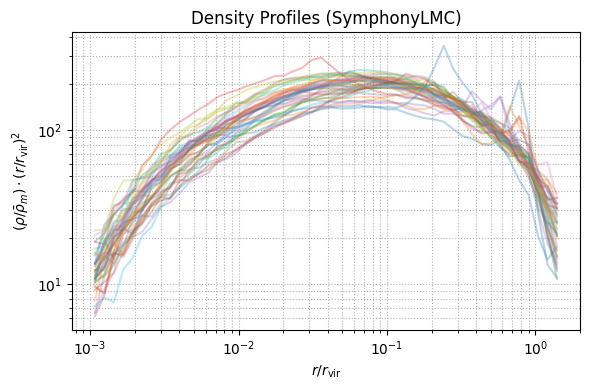

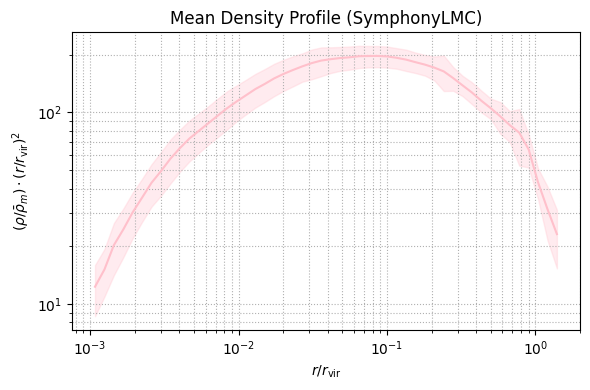

[Done] Plots saved to /Volumes/Atlas/Symphony/output/SymphonyLMC/figures/


In [ ]:
from glob import glob

def plot_density(base_dir, suite_name):
    """
    Plot every halo's scaled density profile (rho * r^2 vs r) and the mean profile of the given suite.
    
    It outputs and saves two plots:
    (1) All halos' profiles overplotted with low opacity.
    (2) Mean profile with 68% (±1 sigma) shaded region.
    """

    profile_dir = f"{base_dir}/output/{suite_name}/density_profiles"
    file_list = sorted(glob(f"{profile_dir}/halo_*_profile.csv"))

    if not file_list:
        print("[Error] No profile files found.")
        return

    # Read all profiles
    all_profiles = []
    for file in file_list:
        df = pd.read_csv(file)
        df["rho_r2"] = df["rho_scaled"] * df["r_scaled"]**2
        all_profiles.append(df)

    # Extract common bin centers
    r_scaled = all_profiles[0]["r_scaled"].values
    rho_r2_all = np.array([df["rho_r2"].values for df in all_profiles])

    # -------- Plot 1: All halo profiles --------
    plt.figure(figsize=(6, 4))
    for rho_r2 in rho_r2_all:
        plt.loglog(r_scaled, rho_r2, alpha=0.3)
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Density Profiles ({suite_name})")
    plt.tight_layout()
    os.makedirs(f"{base_dir}/output/{suite_name}/figures", exist_ok=True)
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/all_halos_profiles.png", dpi=300)
    plt.show()
    plt.close()

    # -------- Plot 2: Mean + 68% range --------
    mean_rho_r2 = np.mean(rho_r2_all, axis=0)
    std_rho_r2 = np.std(rho_r2_all, axis=0)

    plt.figure(figsize=(6, 4))
    plt.loglog(r_scaled, mean_rho_r2, color="pink", label="Mean Profile")
    plt.fill_between(r_scaled, mean_rho_r2 - std_rho_r2, mean_rho_r2 + std_rho_r2,
                     color="pink", alpha=0.3, label=r"$\pm1\sigma$")

    ## ext_df = pd.read_csv('/Volumes/Atlas/Symphony/figure6_LMC.csv')
    ## plt.loglog(ext_df["r/R_vir_host"], ext_df["(r/R_vir)^2 rho/rho_m"],   
    ## color="black", lw=2, label="Extracted LMC Profile (from image)")

    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Mean Density Profile ({suite_name})")
    plt.tight_layout()
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/mean_profile.png", dpi=300)
    plt.show()   
    plt.close()

    print(f"[Done] Plots saved to {base_dir}/output/{suite_name}/figures/")

plot_density("/Volumes/Atlas/Symphony", "SymphonyLMC")

In [ ]:
def veloccity_dispeision(base_dir, suite_name, snap, n_bins, r_min, r_max):
    """
    Measure the radial&total veclocity dispersion and anisotropy profiles of each host halo in a suite at a given snapshot,
    and save the profiles as pandas DataFrame (columns: halo_idx, r_scaled, sigmat_scaled, sigmar_scaled, beta).
    note: all measurements are done in host frame.
    """

    # read and compute essential parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    eps = params['eps'] * h  # kpc
    H0 = params["H0"]  # km/s/Mpc

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        # compute virial velocity
        center = host['x'][-1]
        v_host = host['v'][-1] # km/s
        r_vir = host['rvir']  # kpc
        m_vir = host['m'] # M_sun
        m = m_vir * u.Msun
        r = r_vir * u.kpc
        G_kpc = G.to(u.kpc * (u.km/u.s)**2 / u.Msun)
        v_vir = np.sqrt(G_kpc * m / r).to(u.km / u.s).value  # float, in km/s
        
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x'] # kpc
        v = p[0]['v'] # kpc
        dx = x - center
        dv = v - v_host
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # compute radial and tangential velocities
        r_hat = dx / radi[:, None]
        v_radial = np.sum(dv * r_hat, axis=1)
        v_tangential_sq = np.sum(dv**2, axis=1) - v_radial**2

        # binned statistics
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        sigmar_scaled = []
        sigmat_scaled = []
        beta_profile = []

        for i in range(n_bins):
            in_bin = (radi_scaled >= bins[i]) & (radi_scaled < bins[i+1])
            sigma_r2 = np.var(v_radial[in_bin])
            sigma_t2 = np.mean(v_tangential_sq[in_bin]) # here assumes the mean v_t=0
            sigmar_scaled.append(np.sqrt(sigma_r2) / v_vir)
            sigmat_scaled.append(np.sqrt(sigma_r2 + sigma_t2) / v_vir)

            beta = 1 - sigma_t2 / (2 * sigma_r2)
            beta_profile.append(beta)

        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "sigmar_scaled": sigmar_scaled,
            "sigmat_scaled": sigmat_scaled,
            "beta": beta_profile
        })

        out_path = f"{base_dir}/output/{suite_name}/velocity_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_vel_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} velocity profile saved.")

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyLMC'
veloccity_dispeision(base_dir, suite_name, snap=235, n_bins=40, r_min=0.001, r_max=1.5)

[Saved] Halo 000 velocity profile saved.
[Saved] Halo 001 velocity profile saved.
[Saved] Halo 002 velocity profile saved.
[Saved] Halo 003 velocity profile saved.
[Saved] Halo 004 velocity profile saved.
[Saved] Halo 005 velocity profile saved.
[Saved] Halo 006 velocity profile saved.
[Saved] Halo 007 velocity profile saved.
[Saved] Halo 008 velocity profile saved.
[Saved] Halo 009 velocity profile saved.
[Saved] Halo 010 velocity profile saved.
[Saved] Halo 011 velocity profile saved.
[Saved] Halo 012 velocity profile saved.
[Saved] Halo 013 velocity profile saved.
[Saved] Halo 014 velocity profile saved.
[Saved] Halo 015 velocity profile saved.
[Saved] Halo 016 velocity profile saved.
[Saved] Halo 017 velocity profile saved.
[Saved] Halo 018 velocity profile saved.
[Saved] Halo 019 velocity profile saved.
[Saved] Halo 020 velocity profile saved.
[Saved] Halo 021 velocity profile saved.
[Saved] Halo 022 velocity profile saved.
[Saved] Halo 023 velocity profile saved.
[Saved] Halo 024

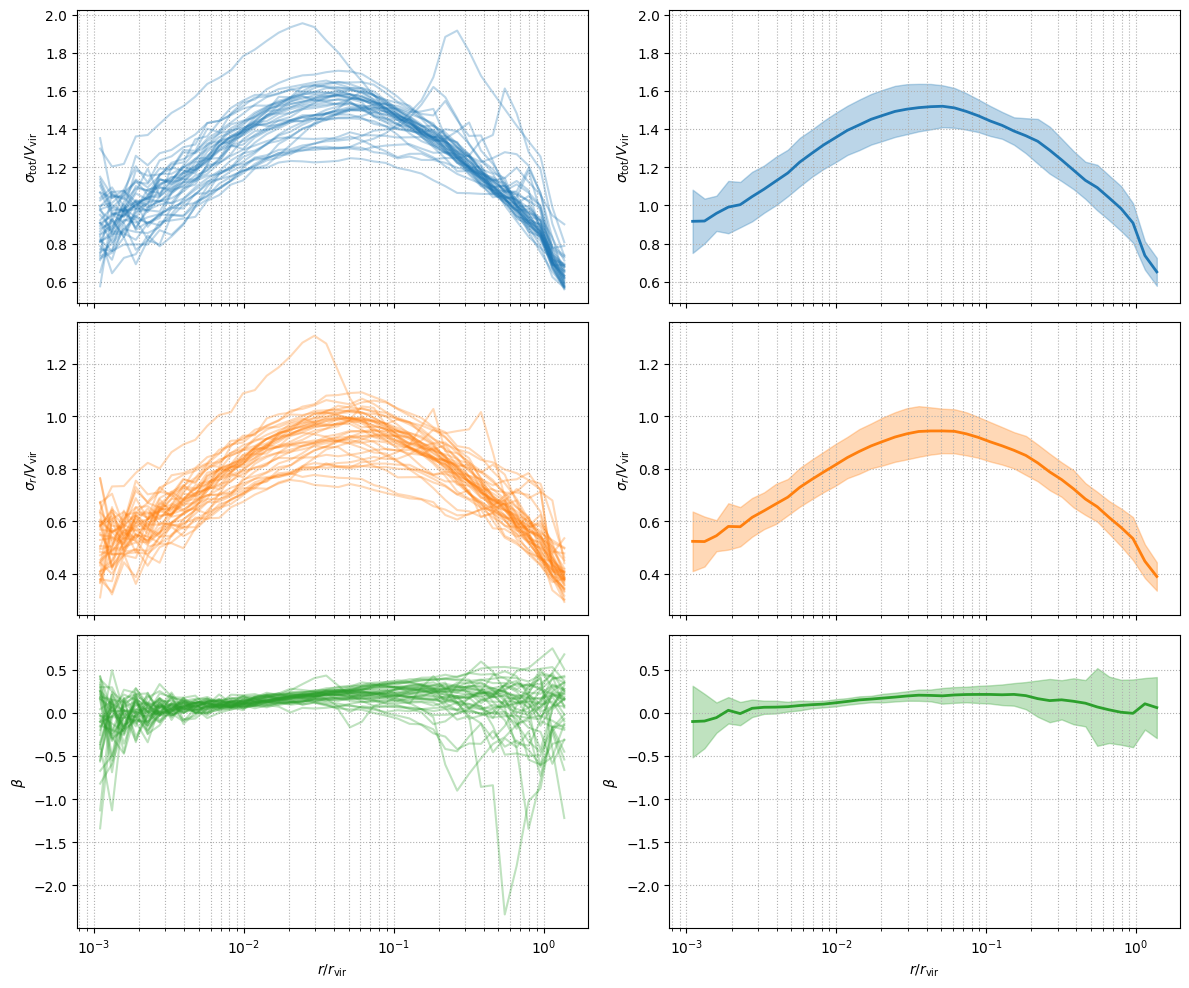

[Saved] profiles saved.


In [22]:
def plot_velocity(base_dir, suite_name):
    """
    Plot and save the velocity dispersion and anisotropy profiles
    """
    input_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
    if not files:
        print("[Error] No CSV files found for velocity profiles.")
        return

    # Load all data arrays
    r = pd.read_csv(os.path.join(input_dir, files[0]))["r_scaled"].values
    sigmat_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigmat_scaled"].values for f in files])
    sigmar_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigmar_scaled"].values for f in files])
    beta_all   = np.array([pd.read_csv(os.path.join(input_dir, f))["beta"].values for f in files])

    fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
    titles = [r"$\sigma_{\mathrm{tot}} / V_{\mathrm{vir}}$", r"$\sigma_r / V_{\mathrm{vir}}$", r"$\beta$"]
    data_arrs = [sigmat_all, sigmar_all, beta_all]
    colors = ["C0", "C1", "C2"]

    for i in range(3):
        y_min = np.nanmin(data_arrs[i])
        y_max = np.nanmax(data_arrs[i])
        y_pad = 0.05 * (y_max - y_min)

        # left: all halos
        for arr in data_arrs[i]:
            axes[i, 0].plot(r, arr, color=colors[i], alpha=0.3)
        axes[i, 0].set_ylabel(titles[i])
        axes[i, 0].set_xscale("log")
        axes[i, 0].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 0].grid(True, which="both", linestyle=":")

        # right: mean ± 1σ
        mean = np.nanmean(data_arrs[i], axis=0)
        std = np.nanstd(data_arrs[i], axis=0)
        axes[i, 1].plot(r, mean, color=colors[i], lw=2)
        axes[i, 1].fill_between(r, mean - std, mean + std, color=colors[i], alpha=0.3)
        axes[i, 1].set_ylabel(titles[i])
        axes[i, 1].set_xscale("log")
        axes[i, 1].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 1].grid(True, which="both", linestyle=":")

    axes[2, 0].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[2, 1].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "velocity_profiles_mean_grid.png"))
    plt.show()
    plt.close(fig)

    print("[Saved] profiles saved.")

plot_velocity("/Volumes/Atlas/Symphony", "SymphonyLMC")

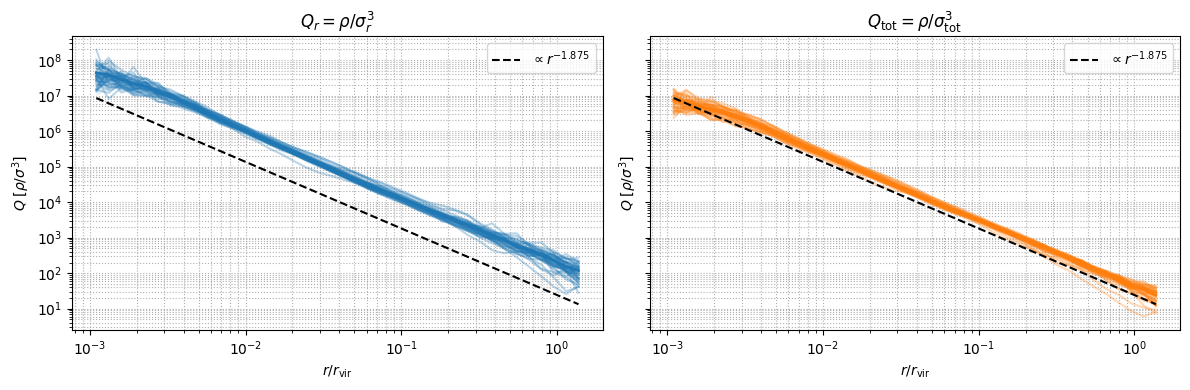

[Saved] PPSD profile figure saved.


In [ ]:
def plot_ppsd_profiles(base_dir, suite_name):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])

    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    ppsd_r = []
    ppsd_tot = []

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigmar = df_vel["sigmar_scaled"].values
        sigmat = df_vel["sigmat_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q_r = np.where(sigmar > 0, rho / sigmar**3, np.nan)
            Q_tot = np.where(sigmat > 0, rho / sigmat**3, np.nan)

        ppsd_r.append(Q_r)
        ppsd_tot.append(Q_tot)

    ppsd_r = np.array(ppsd_r)
    ppsd_tot = np.array(ppsd_tot)
    r = df_rho["r_scaled"].values

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

    for Q_arr in ppsd_r:
        axes[0].plot(r, Q_arr, alpha=0.3, color="C0")
    mean_r = np.nanmean(ppsd_r, axis=0)
    std_r = np.nanstd(ppsd_r, axis=0)
    axes[0].plot(r, mean_r, color="C0", lw=2)
    axes[0].fill_between(r, mean_r - std_r, mean_r + std_r, color="C0", alpha=0.3, linewidth=0.1)
    axes[0].set_title(r"$Q_r = \rho / \sigma_r^3$")

    for Q_arr in ppsd_tot:
        axes[1].plot(r, Q_arr, alpha=0.3, color="C1")
    mean_tot = np.nanmean(ppsd_tot, axis=0)
    std_tot = np.nanstd(ppsd_tot, axis=0)
    axes[1].plot(r, mean_tot, color="C1", lw=2)
    axes[1].fill_between(r, mean_tot - std_tot, mean_tot + std_tot, color="C1", alpha=0.3, linewidth=0.1)
    axes[1].set_title(r"$Q_{\rm tot} = \rho / \sigma_{\rm tot}^3$")

    for ax in axes:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
        ax.set_ylabel(r"$Q \; [\rho / \sigma^3]$")
        ax.grid(True, which="both", linestyle=":")

    r_ref = np.logspace(np.log10(r.min()), np.log10(r.max()), 100)
    norm_r = r_ref[10]  
    Q_ref = mean_r[10] * (r_ref / norm_r)**(-1.875)

    axes[0].plot(r_ref, Q_ref, 'k--', label=r"$\propto r^{-1.875}$")
    axes[1].plot(r_ref, Q_ref, 'k--', label=r"$\propto r^{-1.875}$")

    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "PPSD_profiles.png"))
    plt.show()
    print("[Saved] PPSD profile figure saved.")

plot_ppsd_profiles("/Volumes/Atlas/Symphony", "SymphonyLMC")